# Add watermarks to images


## Problem

You need to add watermarks to hundreds of different images to protect copyright, add branding, or mark drafts.


## Solution

**What's in this recipe:**
- Create simple text watermarks
- Test transformations before applying
- Apply to multiple images automatically

Add watermarks by applying Pillow's `ImageDraw` as a function to all images stored as rows in your table. Uses a custom UDF (relies on PIL/Pillow) to position and style text overlays—gives you full control over watermark placement, font, transparency, and color.

Using Pixeltable, iterate on transformations before adding them to your table. Use `.select()` to define what you want, then `.collect()` to execute and see results (or `.head(n)` to see just the first n rows), without storing changes yet. Once you're satisfied, use `.add_computed_column()` with the same expression to persist results.

For more on this workflow, see [Get fast feedback on transformations](./dev-iterative-workflow.ipynb).


### Setup


In [ ]:
%pip install -qU pixeltable

In [1]:
import pixeltable as pxt
from PIL import Image, ImageDraw, ImageFont

In [2]:
# Create a fresh directory (drop existing if present)
pxt.drop_dir('image_demo', force=True)
pxt.create_dir('image_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'image_demo'.


### Load images


In [3]:
t = pxt.create_table('image_demo.watermarks', {'image': pxt.Image})
t.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000001.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000016.jpg'},
])

Created table 'watermarks'.
Inserting rows into `watermarks`: 2 rows [00:00, 631.53 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

### Iterate: Add watermarks to a few images first


In [4]:
@pxt.udf
def add_watermark(img: Image.Image, text: str) -> Image.Image:
    """Add a watermark to bottom-right corner."""
    img = img.copy().convert('RGBA')
    overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    
    # Draw white text in bottom-right corner
    font = ImageFont.load_default(size=40)
    position = (img.width - 150, img.height - 60)
    draw.text(position, text, font=font, fill=(255, 255, 255, 200))
    
    result = Image.alpha_composite(img, overlay)
    return result.convert('RGB')

image,add_watermark
,

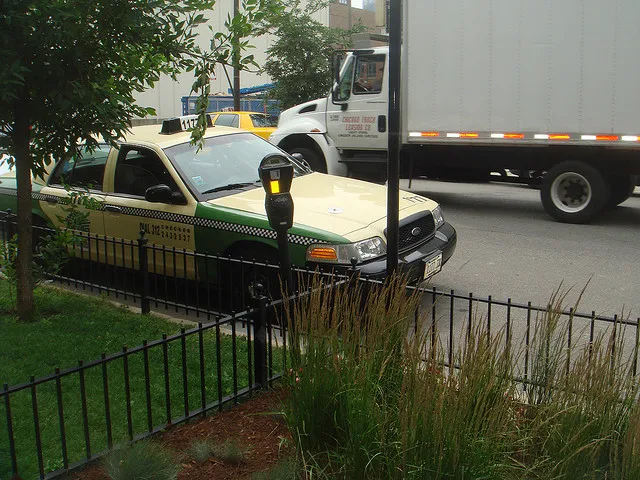
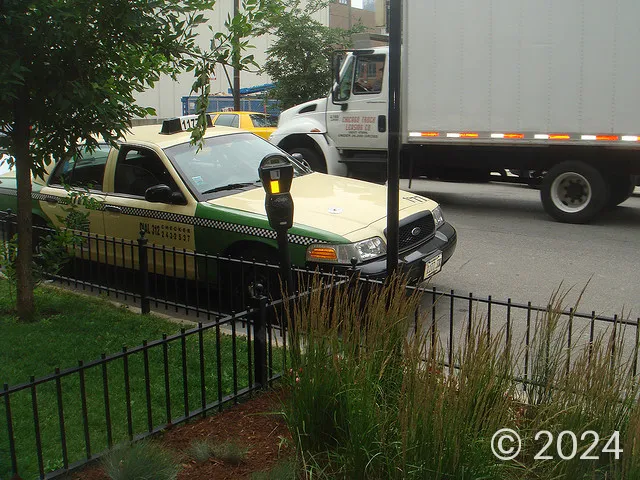

In [5]:
# Test on first image
t.select(t.image, add_watermark(t.image, '© 2024')).head(1)

### Add: Add watermarks to all images in your table

Added 2 column values with 0 errors.


image,watermarked
,
,

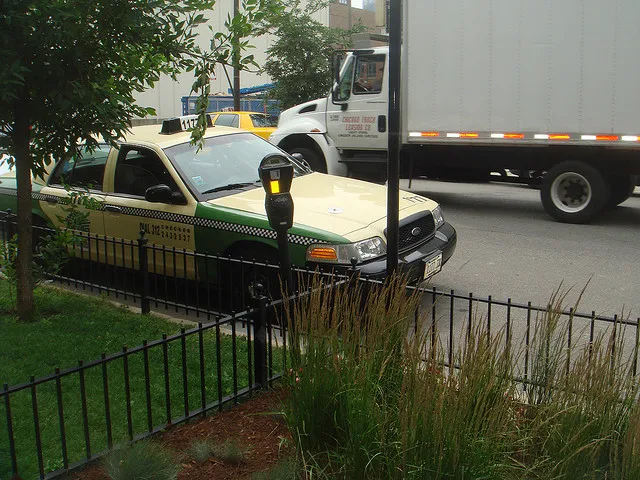
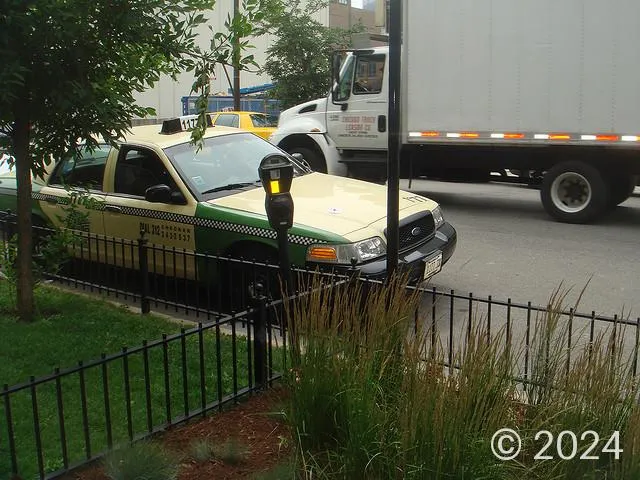
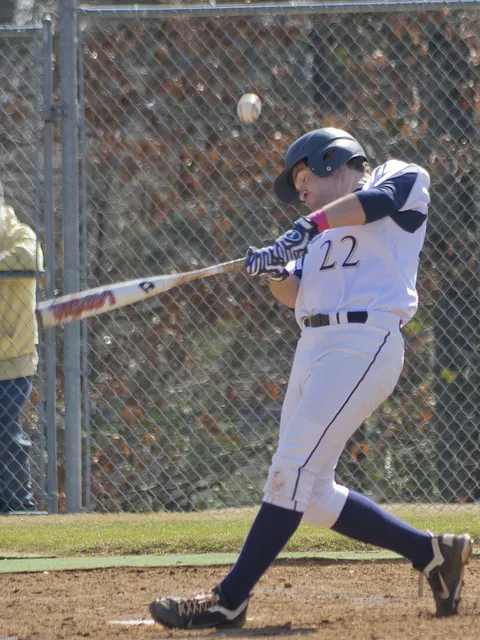
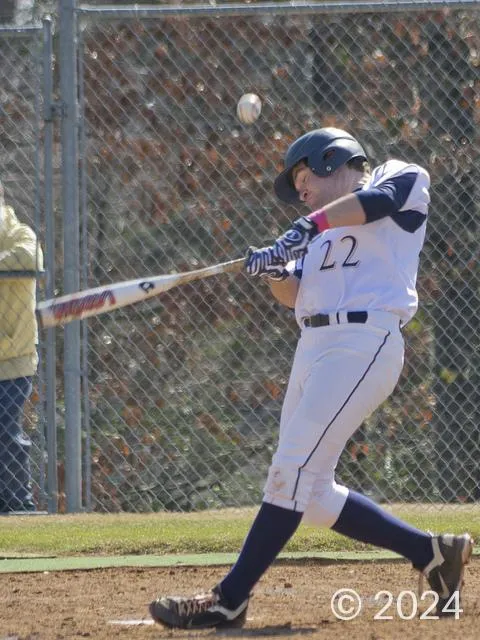

In [6]:
# Add watermark to all images
t.add_computed_column(watermarked=add_watermark(t.image, '© 2024'))

# View all results
t.collect()

## Explanation

**How the watermark technique works:**

This approach creates a transparent overlay on top of each image. The overlay is created with the same dimensions as the image (`Image.new('RGBA', img.size, ...)`), so watermarks adapt automatically whether you're processing small thumbnails or large photos. We draw white text with semi-transparent fill (alpha=200, where 255 is fully opaque), then composite the overlay onto the original image using `Image.alpha_composite()`. Finally, we convert back to RGB since most image formats don't support transparency.

**To customize the UDF:**
- Position: Change the `(x, y)` coordinates in the `position` variable
- Color: Modify the `(R, G, B, Alpha)` fill value (0-255 for each)
- Size: Adjust the font size parameter in `ImageFont.load_default(size=40)`
- Font: Use `ImageFont.truetype('path/to/font.ttf', size)` for custom fonts

**The Pixeltable workflow:**

In traditional databases, `.select()` just picks which columns to view. In Pixeltable, `.select()` also lets you compute new transformations on the fly—define new columns without storing them. This makes `.select()` perfect for testing transformations before you commit them.

When you use `.select()`, you're creating a query that doesn't store anything—it just computes results in memory. Use `.head(n)` to test on a few rows before processing your full dataset. Once satisfied, use `.add_computed_column()` with the same expression to persist results permanently.

For more on this workflow, see [Get fast feedback on transformations](./dev-iterative-workflow.ipynb).

## See also

- [Test transformations with fast feedback loops](./dev-iterative-workflow.ipynb)
- [Transform images with PIL operations](./img-pil-transforms.ipynb)
- *Pillow techniques from [Real Python: Image Processing With the Python Pillow Library](https://realpython.com/image-processing-with-the-python-pillow-library/)*
